`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
import cftime

## Get mixed layer

In [17]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

variables = ['mlotst']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn'],
              source_id=['IPSL-CM6A-LR', 
#                          'MPI-ESM1-2-LR', 
                         'CNRM-ESM2-1', 
                         'CanESM5', 
#                          'MPI-ESM1-2-HR', 
#                          'CMCC-ESM2', 
#                          'GISS-E2-1-G', 
                         'UKESM1-0-LL',
#                          'ACCESS-ESM1-5', 
                         'CanESM5-CanOE' 
#                          'GISS-E2-1-G-CC',
#                          'MPI-ESM-1-2-HAM'
                        ]
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gn = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gn = merge_variables(dd_gn)
# list(dd_new.keys())

temp={}
for name,item in dd_gn.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gn = temp


def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_gn = combine_datasets(
    dd_gn,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gn.keys())
# dd_new_new_gn




--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon']

## Regrid mixed layer

In [18]:
# Regrid
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
targetgrid_ds['lon'] = targetgrid_ds['lon']+180
targetgrid_ds['lon_b'] = targetgrid_ds['lon_b']+180
newcoords = {'x':targetgrid_ds['lon'][0,:],'y':targetgrid_ds['lat'][:,0]}

dd_regrid={}
for name,item in dd_gn.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item['mlotst']).assign_coords(**newcoords).chunk({'time':120})
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 10
  tmp = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 10
  tmp = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 17
  tmp = blockwise(


['IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon']

## Get mixed layer for `gr`
### Does not require regridding

In [19]:
variables = ['mlotst']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gr = merge_variables(dd_gr)

temp={}
for name,item in dd_gr.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gr = temp
# list(dd_new_gr.keys())

dd_gr = combine_datasets(
    dd_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gr.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['MRI-ESM2-0.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon']

In [20]:
dd_mlotst = {**dd_gr, **dd_regrid}

## Annual average and winter average mixed layer for Pacific

In [26]:
# for name, ds in dd_mlotst.items():
#     ds = ds.isel(time = slice(0,239))
#     ds = ds.sel(time=ds.time.dt.season=="JJA").mean('time',keep_attrs=True)
#     dd_mlotst[name] = ds
dd_annual = {}
dd_JJA = {}
for name, ds in dd_mlotst.items():
    ds = ds.isel(time = slice(0,239), x=slice(180,200))
    ds_ann = ds.mean(['time', 'x'],keep_attrs=True)
    ds_JJA = ds.sel(time=ds.time.dt.season=="JJA").isel(x=slice(180,200)).mean(['time', 'x'],keep_attrs=True)
    dd_annual[name] = ds_ann
    dd_JJA[name] = ds_JJA

In [6]:
dd_mlotst['IPSL-CM6A-LR.gn.historical.Omon']


<xarray.Dataset>
Dimensions:      (bnds: 2, time: 1980, x: 360, y: 180)
Coordinates:
  * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds  (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y            (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables:
    area         (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    mlotst       (time, y, x) float64 dask.array<chunksize=(120, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

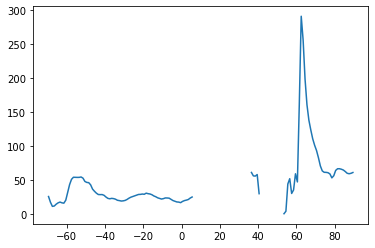

In [8]:
plt.plot(dd_mlotst['CESM2-FV2.gr.historical.Omon'].mlotst.y, dd_mlotst['CESM2-FV2.gr.historical.Omon'].mlotst.isel(time = 0, x = 0))

## Load saved data sets for all longs 

In [22]:
dd = {}
dd['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc')
dd['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc')
dd['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc')
dd['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc')
dd['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc')
dd['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc')
dd['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc')
dd['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc')
dd['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc')
dd['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc')
dd['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc')
dd['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc')
# A = xr.open_mfdataset('AREA.nc')

## Calculate some variables

In [23]:
for name, ds in dd.items():
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])
    ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])

## Load saved data sets for Pacific

In [24]:
dd_x = {}
dd_x['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)

In [27]:
for name, ds in dd_x.items():
    da = dd[name]
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(da['so'], da['thetao'], ds['p']).isel(x=slice(180,200)).mean('x', keep_attrs=True)
    ds['sigma2'] = gsw.sigma2(da['so'],da['thetao']).isel(x=slice(180,200)).mean('x', keep_attrs=True)
    ds['sigma0'] = gsw.sigma0(da['so'],da['thetao']).isel(x=slice(180,200)).mean('x', keep_attrs=True)
    ds['sigma1'] = gsw.sigma1(da['so'],da['thetao']).isel(x=slice(180,200)).mean('x', keep_attrs=True)

## Calculate PCO2 for Pacific

In [28]:
PCO2_x = {}
for name, ds in dd_x.items():
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds['talk']*conversion,par2=ds['dissic']*conversion,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
                        temperature = ds['insitutemp'])
    PCO2_x[name] = results['pCO2_out']

In [ ]:
# fig, ax = plt.subplots(nrows = 1, figsize=[18,12])
plt.rc('font', size = 20)
plt.rc('axes', titlesize= 30)    
plt.rc('axes', labelsize= 30)
plt.rc('figure', titlesize=30)
temp={}

conversion = 3.1536e7 * 83.3
# 3.1536e7 seconds per year
# 83.3 mol C per kg -- 12 gC/mol

ax_idx = 0
for name, ds in dd_annual.items():
    # maybe do mean over the entire circumference so just 
    # take out the where function and mean all x
    ar = ds.mlotst.mean(['x'], keep_attrs=True)
#     ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot(label = name, lw = 3)
    plt.plot(ds.mlotst.y[10:60], ar[10:60], label = name, lw = 3)
    # adds ar to an array 
    temp[name] = ar
#     print(ds.fgco2.lat.y)
    plt.xlabel('Latitude')
    plt.ylabel('Ocean Mixed Layer Thickness Defined by Sigma T [m]')

mn = np.nanmean(list(temp.values()), axis=0)
sd = np.std(list(temp.values()), axis=0)
plt.plot(ds.mlotst.y[10:60], mn[10:60], lw = 6, label = 'Ensemble mean', color = 'black')
plt.ylim([0, 500])
plt.gca().invert_yaxis()

# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')

# zr = xr.zeros_like(dd['CESM2-FV2.gr.historical.Omon'].fgco2)
# zr.isel(x = 0)[10:60].plot(linestyle = 'dashed', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')
# # ax = plt.gca
# # box = ax.get_position()
# # ax.position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='lower right'
#     , borderaxespad=0.
)
plt.title('Circum Antarctic')
plt.rcParams["figure.figsize"] = (25,15)



In [ ]:
# fig, ax = plt.subplots(nrows = 1, figsize=[18,12])
plt.rc('font', size = 20)
plt.rc('axes', titlesize= 30)    
plt.rc('axes', labelsize= 30)
plt.rc('figure', titlesize=30)
temp={}

conversion = 3.1536e7 * 83.3
# 3.1536e7 seconds per year
# 83.3 mol C per kg -- 12 gC/mol

ax_idx = 0
for name, ds in dd_JJA.items():
    # maybe do mean over the entire circumference so just 
    # take out the where function and mean all x
    ar = ds.mlotst.mean(['x'], keep_attrs=True)
#     ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot(label = name, lw = 3)
    plt.plot(ds.mlotst.y[10:60], ar[10:60], label = name, lw = 3)
    # adds ar to an array 
    temp[name] = ar
#     print(ds.fgco2.lat.y)
    plt.xlabel('Latitude')
    plt.ylabel('Ocean Mixed Layer Thickness Defined by Sigma T [m]')

mn = np.nanmean(list(temp.values()), axis=0)
sd = np.std(list(temp.values()), axis=0)
plt.plot(ds.mlotst.y[10:60], mn[10:60], lw = 6, label = 'Ensemble mean', color = 'black')
plt.ylim([0, 500])
plt.gca().invert_yaxis()

# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')

# zr = xr.zeros_like(dd['CESM2-FV2.gr.historical.Omon'].fgco2)
# zr.isel(x = 0)[10:60].plot(linestyle = 'dashed', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')
# # ax = plt.gca
# # box = ax.get_position()
# # ax.position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='lower right'
#     , borderaxespad=0.
)
plt.title('Circum Antarctic JJA')
plt.rcParams["figure.figsize"] = (25,15)



# This is currently the annual
I purposely left it intact when i changed things to JJA

In [ ]:
# fig, ax = plt.subplots(nrows = 1, figsize=[18,12])
plt.rc('font', size = 20)
plt.rc('axes', titlesize= 30)    
plt.rc('axes', labelsize= 30)
plt.rc('figure', titlesize=30)
temp={}

conversion = 3.1536e7 * 83.3
# 3.1536e7 seconds per year
# 83.3 mol C per kg -- 12 gC/mol

ax_idx = 0
for name, ds in dd_mlotst.items():
    # maybe do mean over the entire circumference so just 
    # take out the where function and mean all x
    ar = ds.mlotst.isel(time = slice(0,239)).mean(['time', 'x'], keep_attrs=True)
#     ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot(label = name, lw = 3)
    plt.plot(ds.mlotst.y[10:60], ar[10:60], label = name, lw = 3)
    # adds ar to an array 
    temp[name] = ar
#     print(ds.fgco2.lat.y)
    plt.xlabel('Latitude')
    plt.ylabel('Ocean Mixed Layer Thickness Defined by Sigma T [m]')

mn = np.nanmean(list(temp.values()), axis=0)
sd2 = np.std(list(temp.values()), axis=0)
plt.plot(ds.mlotst.y[10:60], mn[10:60], lw = 6, label = 'Ensemble mean', color = 'black')
plt.gca().invert_yaxis()
# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')

# zr = xr.zeros_like(dd['CESM2-FV2.gr.historical.Omon'].fgco2)
# zr.isel(x = 0)[10:60].plot(linestyle = 'dashed', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')
# # ax = plt.gca
# # box = ax.get_position()
# # ax.position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='lower right'
#     , borderaxespad=0.
)
plt.title('Circum Antarctic')
plt.rcParams["figure.figsize"] = (25,15)



In [ ]:
# fig, ax = plt.subplots(nrows = 1, figsize=[18,12])
plt.rc('font', size = 20)
plt.rc('axes', titlesize= 30)    
plt.rc('axes', labelsize= 30)
plt.rc('figure', titlesize=30)
temp={}

conversion = 3.1536e7 * 83.3
# 3.1536e7 seconds per year
# 83.3 mol C per kg -- 12 gC/mol

ax_idx = 0
for name, ds in dd_mlotst.items():
    # maybe do mean over the entire circumference so just 
    # take out the where function and mean all x
    ar = ds.mlotst.mean(['x'], keep_attrs=True)
#     ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot(label = name, lw = 3)
    plt.plot(ds.mlotst.y[10:60], ar[10:60], label = name, lw = 3)
    # adds ar to an array 
    temp[name] = ar
#     print(ds.fgco2.lat.y)
    plt.xlabel('Latitude')
    plt.ylabel('Ocean Mixed Layer Thickness Defined by Sigma T [m]')

mn = np.nanmean(list(temp.values()), axis=0)
sd2 = np.std(list(temp.values()), axis=0)
plt.plot(ds.mlotst.y[10:60], mn[10:60], lw = 6, label = 'Ensemble mean', color = 'black')
plt.gca().invert_yaxis()
# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')

# zr = xr.zeros_like(dd['CESM2-FV2.gr.historical.Omon'].fgco2)
# zr.isel(x = 0)[10:60].plot(linestyle = 'dashed', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')
# # ax = plt.gca
# # box = ax.get_position()
# # ax.position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='lower right'
#     , borderaxespad=0.
)
plt.title('Circum Antarctic JJA')
plt.rcParams["figure.figsize"] = (25,15)



In [13]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

variables = ['areacello']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Ofx'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

# dd_gr = merge_variables(dd_gr)

# temp={}
# for name,item in dd_gr.items():
#     #print(name)
#     #print(item.data_vars)
#     present = item.data_vars
#     if all(i in present for i in variables):
#         #print(name)
#         temp[name]=item
# dd_gr = temp
# list(dd_new_gr.keys())

dd_gr = combine_datasets(
    dd_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gr.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['GFDL-ESM4.gr.historical.Ofx']

In [14]:
newcoords = {'x':dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello['x'], 'y':dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}

for name, ds in dd.items():
    dd[name] = ds.assign_coords(**newcoords)
    
newercoords = {'y':dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}

for name, ds in dd_x.items():
    dd_x[name] = ds.assign_coords(**newercoords)


In [15]:
A = dd_gr['GFDL-ESM4.gr.historical.Ofx'].mean([ 'x'],keep_attrs=True).areacello
A

<xarray.DataArray 'areacello' (y: 180)>
dask.array<mean_agg-aggregate, shape=(180,), dtype=float32, chunksize=(180,), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    cell_methods:   area: sum
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Grid-Cell Area
    original_name:  areacello
    standard_name:  cell_area
    units:          m²

## Upper ocean PCO2 with mixed layer depth, `sigma0` of outgassing, and `sigma1` of max PCO2 from upper 500m

`sigma0` of outgassing from 1000_PCO2_hist.ipynb
> The `sigma0` is all sigma0 with positive co2 flux, so everywhere there is outgassing rather than ingassing

`sigma1` of PCO2 from 500_PCO2_hist.ipynb

/tmp/ipykernel_353/1922945440.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ds['y'],ds['lev'], PCO2_x[name], vmin = 300, vmax = 500)
/tmp/ipykernel_353/1922945440.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ds['y'],ds['lev'], PCO2_x[name], vmin = 300, vmax = 500)
/tmp/ipykernel_353/1922945440.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since

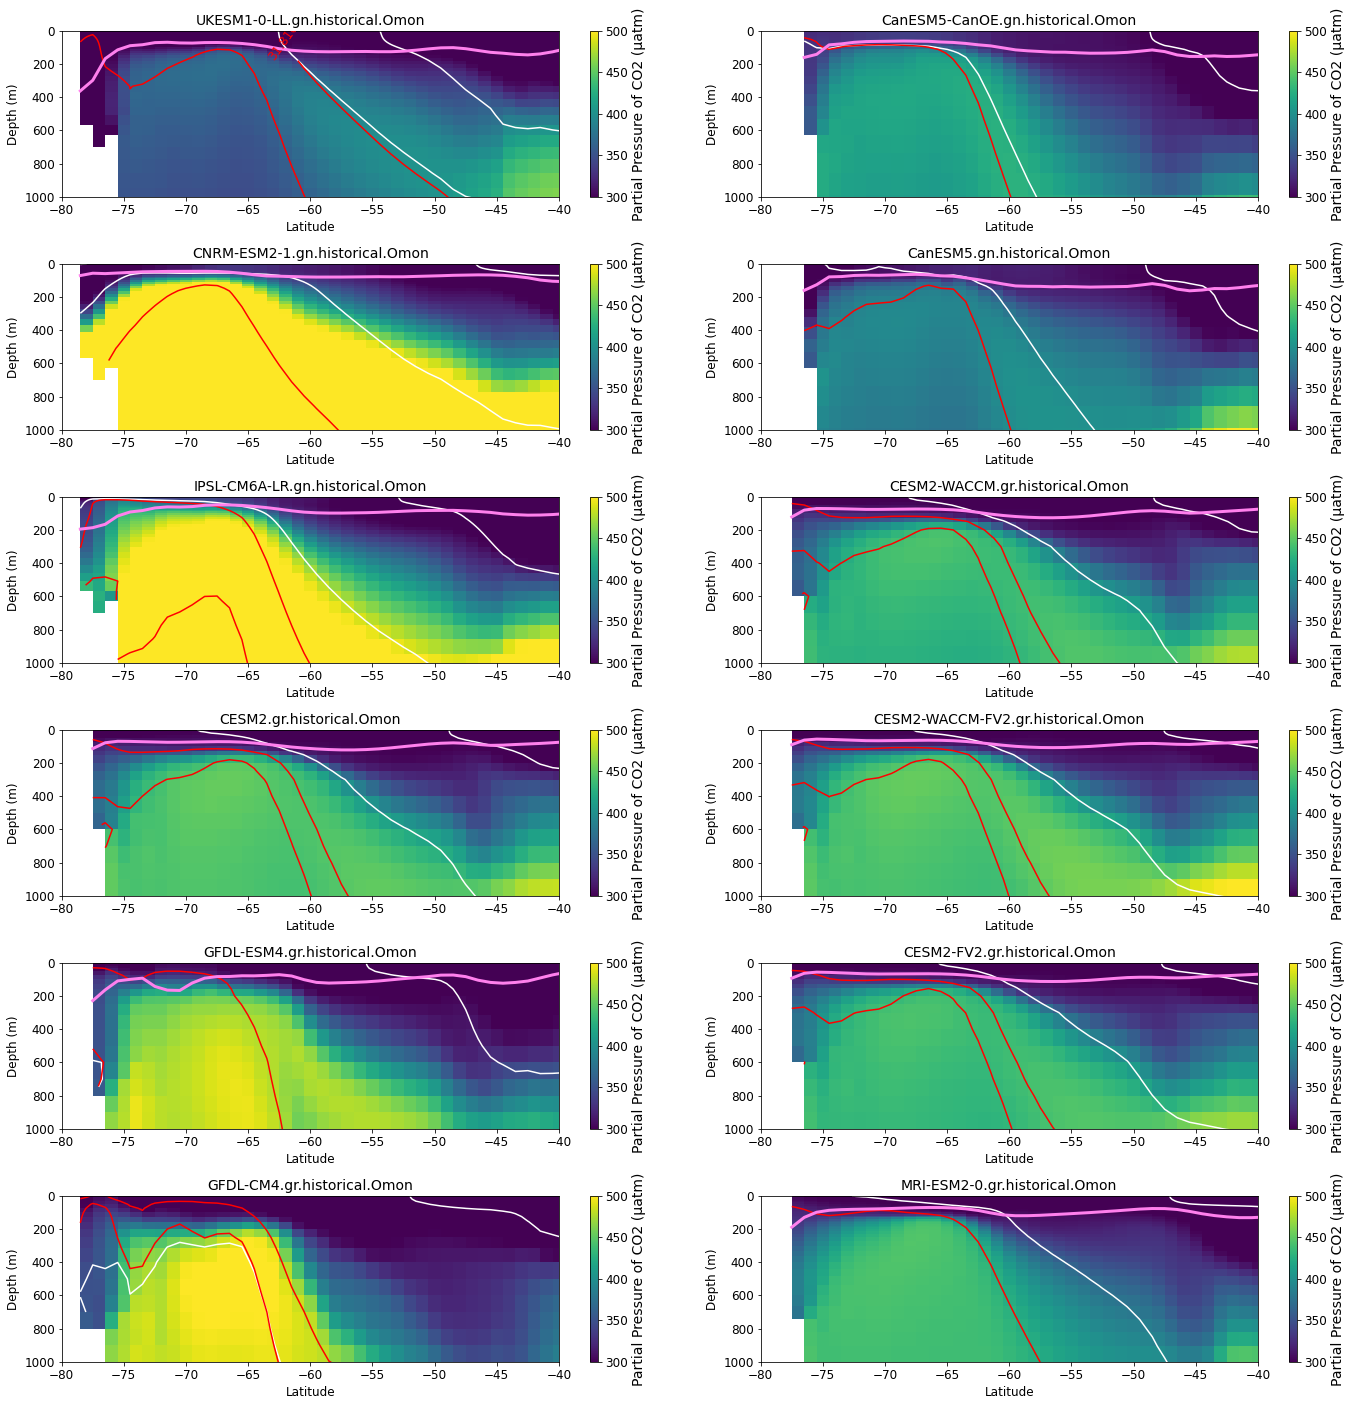

In [48]:
# This one is with sigma0 and annual mixed layer

fig, axarr = plt.subplots(nrows = 6, ncols = 2, figsize=[20,20])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 14)    
plt.rc('axes', labelsize= 14)
plt.rc('figure', titlesize=16)

ax_idx = 0
for name, ds in dd_x.items():
    ax = axarr.flat[ax_idx]
    conversion =  1e6/1035
#     results = pyco2.sys(par1=ds['talk']*conversion,par2=ds['dissic']*conversion,par1_type=1,par2_type=2,
#                         pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
#                         temperature = ds['insitutemp'])
    ax.set_xlim([-80,-40])
    ax.set_ylim([0,1000])
    im = ax.pcolormesh(ds['y'],ds['lev'], PCO2_x[name], vmin = 300, vmax = 500)
    if name == 'UKESM1-0-LL.gn.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.46, 27.13], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[31.816, 32.289], colors = 'r')
    elif name == 'CanESM5-CanOE.gn.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.29, 27.54], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[32.289, 32.447], colors = 'r')
        
    elif name == 'CNRM-ESM2-1.gn.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[25.96, 27.13], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[32.132, 32.289], colors = 'r')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[32.105], colors = 'k')
    elif name == 'CanESM5.gn.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.29, 27.29], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[32.289, 32.447], colors = 'r')
    elif name == 'IPSL-CM6A-LR.gn.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.46, 27.38], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[32.289, 32.447], colors = 'r')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[32.4], colors = 'k')
    elif name == 'CESM2-WACCM.gr.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.13, 27.04], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[32.132, 32.289], colors = 'r')
    elif name == 'CESM2.gr.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.13, 27.04], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[32.132, 32.289], colors = 'r')
    elif name == 'CESM2-WACCM-FV2.gr.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[25.88, 26.96], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[32.132, 32.289], colors = 'r')
    elif name == 'GFDL-ESM4.gr.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.63, 27.71], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[32.289, 32.447], colors = 'r')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[32.105], colors = 'k')
    elif name == 'CESM2-FV2.gr.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[25.96, 26.96], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[32.132, 32.289], colors = 'r')
    elif name == 'GFDL-CM4.gr.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.63, 27.63], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[32.132, 32.289], colors = 'r')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[32.105], colors = 'k')
    elif name == 'MRI-ESM2-0.gr.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.4, 27.21], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma1'],levels=[32.132, 32.289], colors = 'r')
    
    # not sure why but CESM2 models, GFDL-ESM4, and MRI-ESM2-0 in dd_annual are datasets not data arrays so this is just a hack
    # likely a dumb way of doing it but I can deal with it later
    if name == 'CESM2-WACCM.gr.historical.Omon' or name == 'CESM2.gr.historical.Omon' or name == 'CESM2-FV2.gr.historical.Omon' or name == 'CESM2-WACCM-FV2.gr.historical.Omon' or name == 'GFDL-ESM4.gr.historical.Omon' or name == 'MRI-ESM2-0.gr.historical.Omon' :
        ax.plot(dd_annual[name].y, dd_annual[name].mlotst, color = '#ff80ed', lw = 3)
    # GFDL-CM4 doesn't have mixed layer
    elif name != 'GFDL-CM4.gr.historical.Omon':
        ax.plot(dd_annual[name].y, dd_annual[name], color = '#ff80ed', lw = 3)
#     CS = ax.contour(ds['y'],ds['lev'],ds['sigma2'],levels=[35.5, 36, 36.5, 36.75, 37], colors = 'w')
    ax.clabel(CS, inline=1, fontsize=12, manual = False)
    cbar = plt.colorbar(im,ax=ax)
    ax.invert_yaxis()
    cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
    ax.set_title(name)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Depth (m)')
    ax_idx += 1

In [42]:
name

'MRI-ESM2-0.gr.historical.Omon'

In [35]:
dd_annual['CanESM5-CanOE.gn.historical.Omon']

<xarray.DataArray (y: 180)>
dask.array<mean_agg-aggregate, shape=(180,), dtype=float32, chunksize=(180,), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    regrid_method:  bilinear

In [36]:
dd_annual[name]

<xarray.Dataset>
Dimensions:  (y: 180)
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    mlotst   (y) float32 dask.array<chunksize=(180,), meta=np.ndarray>
Attributes: (12/50)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    674885.0
    branch_time_in_parent:   25185.0
    case_id:                 6
    ...                      ...
    variant_info:            CMIP6 CESM2 hindcast (1850-2015) with high-top a...
    variant_label:           r3i1p1f1
    netcdf_tracking_ids:     hdl:21.14100/c81c9caf-28a7-4150-b7e4-9e2beb572577
    version_id:              v20190808
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.NCAR.CESM2-WACCM.historical.r3i1p1f1.Omon.m...